In [7]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from algora.base import BaseEstimator
from algora.metrics.distance import euclidean_distance

random.seed(1111)


class KMeans(BaseEstimator):
    """Partition a dataset into K clusters.

    Finds clusters by repeatedly assigning each data point to the cluster with
    the nearest centroid and iterating until the assignments converge (meaning
    they don't change during an iteration) or the maximum number of iterations
    is reached.

    Parameters
    ----------

    K : int
        The number of clusters into which the dataset is partitioned.
    max_iters: int
        The maximum iterations of assigning points to the nearest cluster.
        Short-circuited by the assignments converging on their own.
    init: str, default 'random'
        The name of the method used to initialize the first clustering.

        'random' - Randomly select values from the dataset as the K centroids.
        '++' - Select a random first centroid from the dataset, then select
               K - 1 more centroids by choosing values from the dataset with a
               probability distribution proportional to the squared distance
               from each point's closest existing cluster. Attempts to create
               larger distances between initial clusters to improve convergence
               rates and avoid degenerate cases.
    """
    y_required = False

    def __init__(self, K=5, max_iters=100, init='random'):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
        self.init = init

    def _initialize_centroids(self, init):
        """Set the initial centroids."""

        if init == 'random':
            self.centroids = [self.X[x] for x in
                              random.sample(range(self.n_samples), self.K)]
        elif init == '++':
            self.centroids = [random.choice(self.X)]
            while len(self.centroids) < self.K:
                self.centroids.append(self._choose_next_center())
        else:
            raise ValueError('Unknown type of init parameter')

    def _predict(self, X=None):
        """Perform clustering on the dataset."""
        self._initialize_centroids(self.init)
        centroids = self.centroids

        # Optimize clusters
        for _ in range(self.max_iters):
            self._assign(centroids)
            centroids_old = centroids
            centroids = [self._get_centroid(cluster) for cluster in self.clusters]

            if self._is_converged(centroids_old, centroids):
                break

        self.centroids = centroids

        return self._get_predictions()

    def _get_predictions(self):
        predictions = np.empty(self.n_samples)

        for i, cluster in enumerate(self.clusters):
            for index in cluster:
                predictions[index] = i
        return predictions

    def _assign(self, centroids):

        for row in range(self.n_samples):
            for i, cluster in enumerate(self.clusters):
                if row in cluster:
                    self.clusters[i].remove(row)
                    break

            closest = self._closest(row, centroids)
            self.clusters[closest].append(row)

    def _closest(self, fpoint, centroids):
        """Find the closest centroid for a point."""
        closest_index = None
        closest_distance = None
        for i, point in enumerate(centroids):
            dist = euclidean_distance(self.X[fpoint], point)
            if closest_index is None or dist < closest_distance:
                closest_index = i
                closest_distance = dist
        return closest_index

    def _get_centroid(self, cluster):
        """Get values by indices and take the mean."""
        return [np.mean(np.take(self.X[:, i], cluster)) for i in range(self.n_features)]

    def _dist_from_centers(self):
        """Calculate distance from centers."""
        return np.array([min([euclidean_distance(x, c) for c in self.centroids]) for x in self.X])

    def _choose_next_center(self):
        distances = self._dist_from_centers()
        probs = distances / distances.sum()
        cumprobs = probs.cumsum()
        r = random.random()
        ind = np.where(cumprobs >= r)[0][0]
        return self.X[ind]

    def _is_converged(self, centroids_old, centroids):
        """Check if the distance between old and new centroids is zero."""
        distance = 0
        for i in range(self.K):
            distance += euclidean_distance(centroids_old[i], centroids[i])
        return distance == 0

    def plot(self, ax=None, holdon=False):
        sns.set(style="white")

        data = self.X

        if ax is None:
            _, ax = plt.subplots()



        for i, index in enumerate(self.clusters):
            point = np.array(data[index]).T
            ax.scatter(*point, c=sns.color_palette("hls", self.K + 1)[i])

        for point in self.centroids:
            ax.scatter(*point, marker='x', linewidths=10)

        if not holdon:
            plt.show()


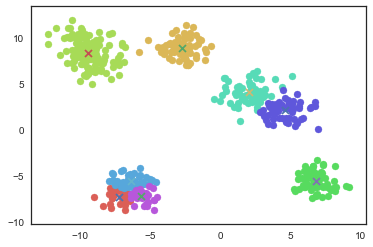

In [10]:
import numpy as np
from sklearn.datasets import make_blobs

from algora.kmeans import KMeans


def kmeans_example(plot=False):
    X, y = make_blobs(centers=8, n_samples=500, n_features=2,
                      shuffle=True, random_state=42)
    clusters = len(np.unique(y))
    k = KMeans(K=clusters, max_iters=150, init='++')
    k.fit(X)
    k.predict()

    if plot:
        k.plot()


if __name__ == '__main__':
    kmeans_example(plot=True)
